# DFT Plot of notable neighborhoods
#### Author: Duke Yang @ NYU CUSP
###### TODO: FFT computation result and DFT matrix multiplication different. Why?

In [127]:
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from scipy import signal

from numpy import array as arr
import matplotlib
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from pprint import pprint
import sympy

sympy.init_printing(pretty_print=True, use_latex='mathjax')

In [2]:
# __DATA_FILE_PATH__ = __YOUR_PATH_HERE__
__DATA_FILE_PATH__ = '../data/DEP_NTANM_NZONLY_311_Service_Requests_from_2010_to_Present.csv'
__COMPLAINT_TYPES__ = [
'Noise - Vehicle', 'Noise - Street/Sidewalk', 'Noise - Commercial',
       'Noise - Residential', 'Noise', 'Noise - Park',
       'Noise - Helicopter', 'Noise - House of Worship',
       'Collection Truck Noise'
#     , 'Noise Survey'
]

In [3]:
def _convert_dt(dt):
    try:
        return pd.to_datetime(dt, format='%Y-%m-%d %H:%M:%S')
    except:
        return np.nan


__RAW_DF__ = pd.read_csv(
    __DATA_FILE_PATH__
    , converters={k: _convert_dt for k in ['Created Date', 'Closed Date', 'Due Date' , 'Resolution Action Updated Date']}
)

### Group by each day

In [7]:
grp_dt = __RAW_DF__.copy(deep=True)
grp_dt.set_index('Created Date', inplace=True)

grp_dt = grp_dt.groupby(['ntaname', pd.Grouper(freq='D')]).agg(
    {
        'Agency': 'count'
    }
)
grp_dt.rename(
    mapper={'Agency': 'count'}
    , axis=1
    , inplace=True
)
grp_dt.head()

count
ntaname Created Date       
Airport 2010-06-10        1
        2012-06-14        1
        2016-07-11        1
        2017-01-07        1
        2017-04-14        1

## Compute DFT of each neighborhood's daily noise complaint counts as input signal (T=365)

In [228]:
def get_dft(ntanm):
    """
    Returns freq, dft
    """
    _dt = pd.DataFrame(pd.date_range(start='2010-01-01', end='2019-12-31'))
    _dt['count'] = 0
    _dt.set_index(0, inplace=True)
    _dt = _dt.loc[grp_dt.loc[ntanm].index[0]:grp_dt.loc[ntanm].index[-1]]
    _df = _dt.merge(grp_dt.loc[ntanm], how='outer', left_index=True, right_index=True)
    _df.fillna(0, inplace=True)
    _df.drop(labels=['count_x'], axis=1, inplace=True)
    
    # calc. DFT
    _l = _df.shape[0]
    dfts = scipy.linalg.dft(_l) @ _df
    freq = np.fft.fftshift(np.fft.fftfreq(_l, d=1/365.25))
    dft = np.fft.fftshift(np.real(dfts)[:])
    return freq, dft


### Hotspot

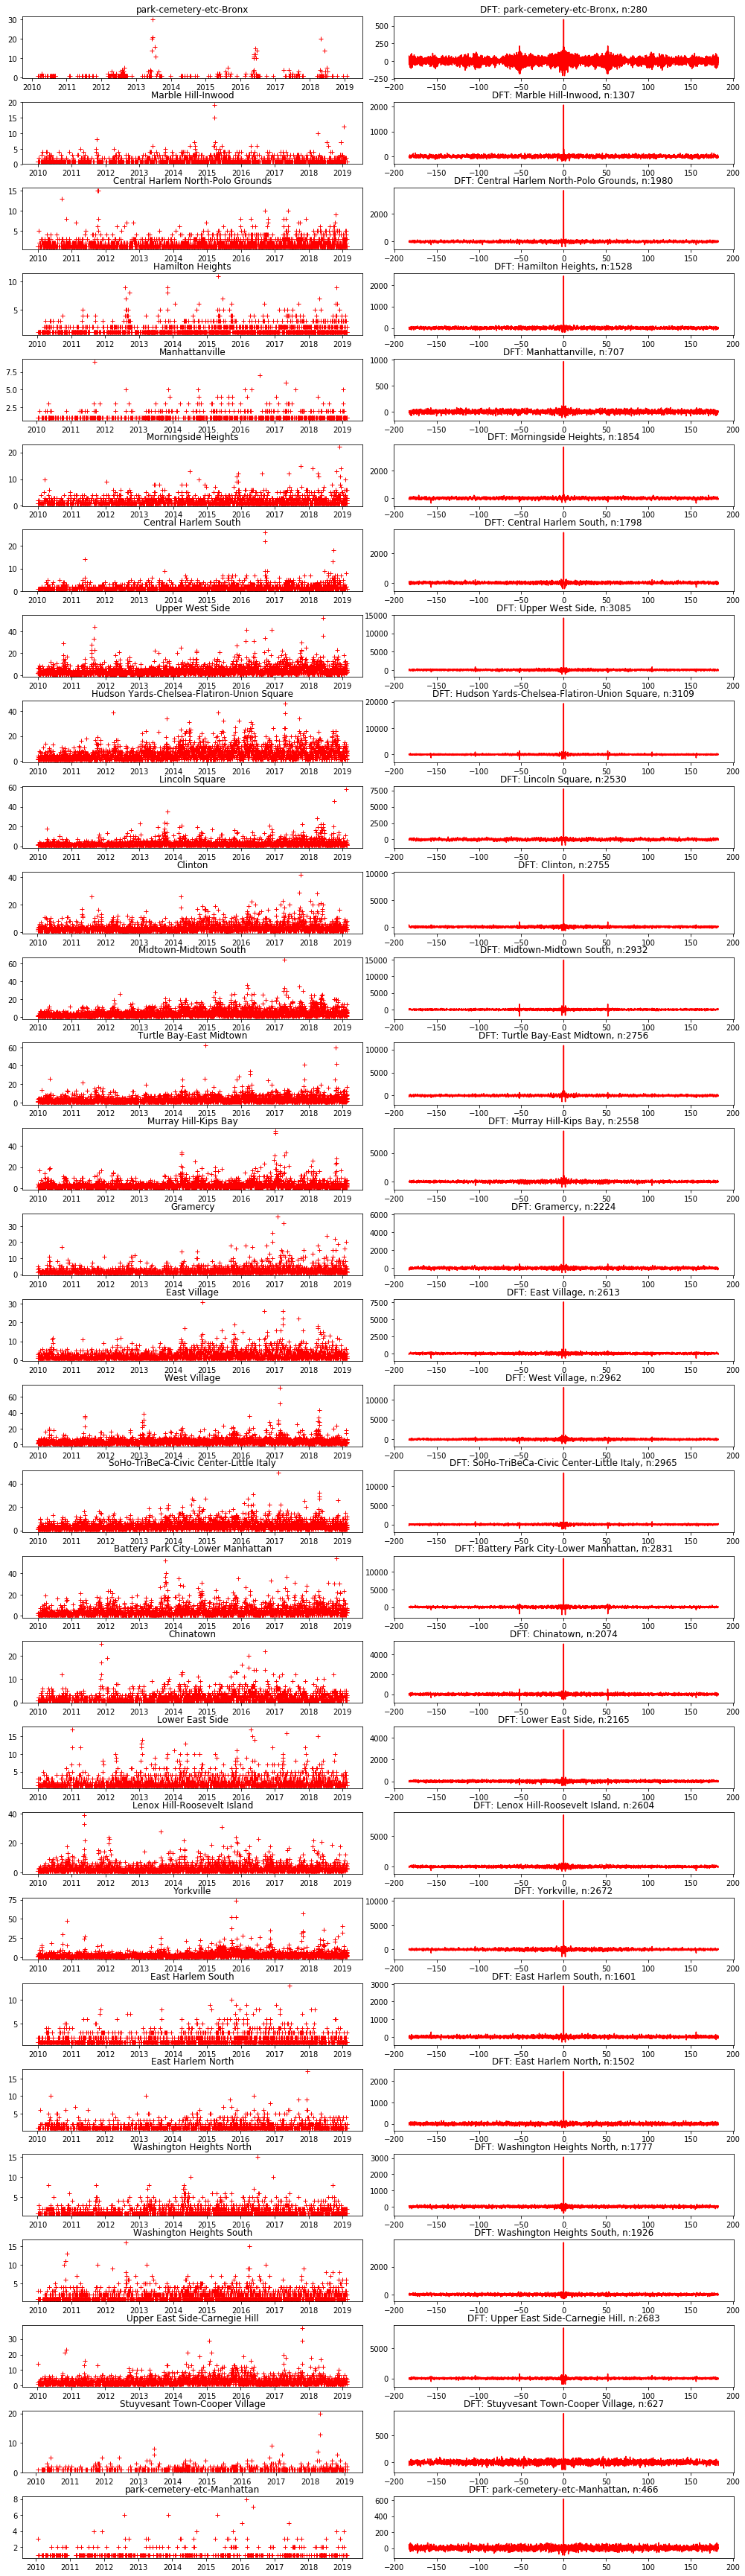

In [236]:
from datetime import datetime

hotspot_nbs = [
    'park-cemetery-etc-Bronx',
    'Marble Hill-Inwood',
    'Central Harlem North-Polo Grounds',
    'Hamilton Heights',
    'Manhattanville',
    'Morningside Heights',
    'Central Harlem South',
    'Upper West Side',
    'Hudson Yards-Chelsea-Flatiron-Union Square',
    'Lincoln Square',
    'Clinton',
    'Midtown-Midtown South',
    'Turtle Bay-East Midtown',
    'Murray Hill-Kips Bay',
    'Gramercy',
    'East Village',
    'West Village',
    'SoHo-TriBeCa-Civic Center-Little Italy',
    'Battery Park City-Lower Manhattan',
    'Chinatown',
    'Lower East Side',
    'Lenox Hill-Roosevelt Island',
    'Yorkville',
    'East Harlem South',
    'East Harlem North',
    'Washington Heights North',
    'Washington Heights South',
    'Upper East Side-Carnegie Hill',
    'Stuyvesant Town-Cooper Village',
    'park-cemetery-etc-Manhattan'
]

plt.close('all')
ntanms = sorted(grp_dt.index.levels[0])
fig, axs = plt.subplots(len(hotspot_nbs), 2, figsize=(14, 48)
                       )
plt.tight_layout()



for i, ntanm in enumerate(hotspot_nbs):
    # Time Series
    axs[i][0].plot(
        grp_dt.loc[ntanm].index
        , grp_dt.loc[ntanm]
        ,'r+'
    )
    axs[i][0].set_title('%s' % ntanm)
    
    # DFT
    freq, dft = zip(*sorted(list(zip(*get_dft(ntanm))), key=lambda t: t[0]))
    axs[i][1].plot(freq, arr(dft), 'r-')
    axs[i][1].set_title('DFT: %s, n:%d' % (ntanm, grp_dt.loc[ntanm].index.size))
    

plt.show()

### Daily Count by Neighborhood SVD result: $u_0 \in U, \, M_{count}=USV^{T}$

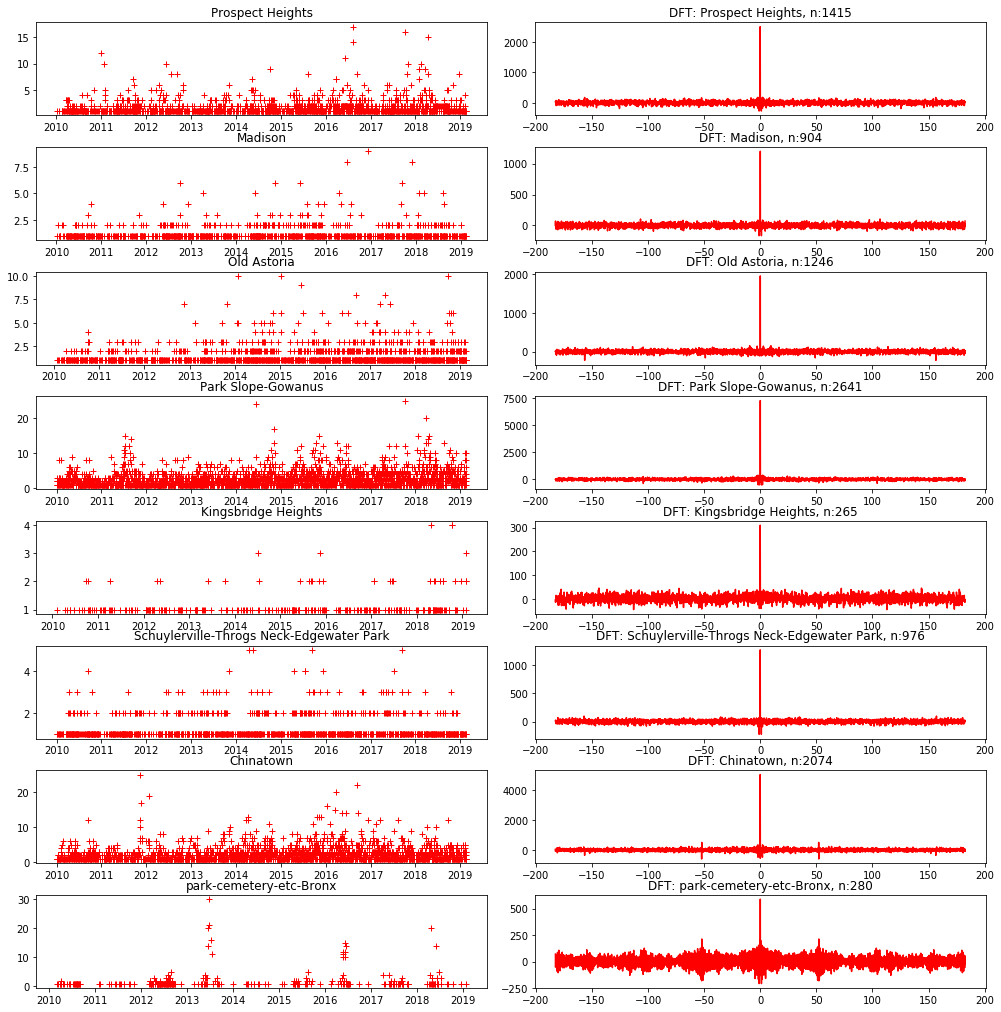

In [231]:
from datetime import datetime

u1_nbs = ['Prospect Heights',
 'Madison',
 'Old Astoria',
 'Park Slope-Gowanus',
 'Kingsbridge Heights',
 'Schuylerville-Throgs Neck-Edgewater Park',
 'Chinatown',
 'park-cemetery-etc-Bronx']

plt.close('all')
ntanms = sorted(grp_dt.index.levels[0])
fig, axs = plt.subplots(len(u1_nbs), 2, figsize=(14, 14)
                       )
plt.tight_layout()



for i, ntanm in enumerate(u1_nbs):
    # Time Series
    axs[i][0].plot(
        grp_dt.loc[ntanm].index
        , grp_dt.loc[ntanm]
        ,'r+'
    )
    axs[i][0].set_title('%s' % ntanm)
    
    # DFT
    freq, dft = zip(*sorted(list(zip(*get_dft(ntanm))), key=lambda t: t[0]))
    axs[i][1].plot(freq, arr(dft), 'r-')
    axs[i][1].set_title('DFT: %s, n:%d' % (ntanm, grp_dt.loc[ntanm].index.size))
    

plt.show()